# Loading and Preprocessing Data with TensorFlow

## The tf.data API

In [1]:
import tensorflow as tf

2025-01-11 13:42:47.362900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 13:42:47.520964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736624567.573817    4287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736624567.588483    4287 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 13:42:47.737246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
X = tf.range(10) ## Any data tensor

I0000 00:00:1736624569.593635    4287 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9442 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
dataset = tf.data.Dataset.from_tensor_slices(X)

In [4]:
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


2025-01-11 13:42:49.717590: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
X_nested = {"a": ([1,2,3], [4,5,6]), "b": [7,8,9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


2025-01-11 13:42:49.729223: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Chaining Transformations

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
## Repeat returns a new dataset that repeats the items of the original dataset three times.
## Batch method creates a new dataset where it groups the items of the previous dataset into batches of 7
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


The dataset methods do <b>not</b> modify datasets--they create new ones.

In [8]:
dataset = dataset.map(lambda x: x * 2) # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


2025-01-11 13:42:49.777351: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [10]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### Shuffling the Data

In [11]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


If the dataset is too large to fit in memory, then try these methods:
- Linux has built in <i>shuf</i> command
- If you have multiple files, read them in simultaneously to interweave

### Interleaving Lines from Multiple Files

In [12]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [13]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [14]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)  ## Shuffles by default, set shuffle=False otherwise

In [15]:
n_readers = 5 ## Five files at a time
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers,
    num_parallel_calls=2 ### For parallel reading
) 

In [16]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442', shape=(), dtype=string)


2025-01-11 13:42:51.312714: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preprocessing the Data

In [17]:
# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [18]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [19]:
preprocess(b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204396, -0.39210168, -0.5277444 ,
        -0.26334172,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together

In [20]:
### Helper function that will create and return a dataset that will load California housing data 
### from multiple CSV files, preprocess it, shuffle it, and batch it
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None, 
                      n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                      batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_parse_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

### Prefetching

Prefetching is when the program/TensorFlow is loading the next batch while the current batch is being used by the model. 

### Using the Dataset with Keras

In [21]:
train_set = csv_reader_dataset(train_filepaths)
val_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=val_set, epochs=5)

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


I0000 00:00:1736624572.013197    4372 service.cc:148] XLA service 0x72be78004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736624572.013328    4372 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-11 13:42:52.025596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736624572.055276    4372 cuda_dnn.cc:529] Loaded cuDNN version 90300


    235/Unknown 1s 646us/step - loss: 1.6484

I0000 00:00:1736624572.342549    4372 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    363/Unknown 1s 1ms/step - loss: 1.4141  

2025-01-11 13:42:52.788682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:52.788705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436
/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4127 - val_loss: 2.0452
Epoch 2/5
118/363 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.6476

2025-01-11 13:42:53.090564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:53.090587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7226 - val_loss: 0.7649
Epoch 3/5


2025-01-11 13:42:53.448436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:53.448459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436
2025-01-11 13:42:53.580650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-11 13:42:53.580680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:53.580687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.4968 - val_loss: 3.3320
Epoch 4/5


2025-01-11 13:42:53.908046: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:53.908072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436
2025-01-11 13:42:54.031833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:54.031857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4530 - val_loss: 3.9546
Epoch 5/5


2025-01-11 13:42:54.366831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:54.366856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436
2025-01-11 13:42:54.492212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:54.492236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.7089 - val_loss: 9.3437


2025-01-11 13:42:54.940817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:54.940841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


In [23]:
test_mse = model.evaluate(test_set)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4519


2025-01-11 13:42:55.180008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4199245752676308571
2025-01-11 13:42:55.180032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6863315435264561436


In [24]:
test_mse

0.43826407194137573

## The TFRecord Format

The TFRecord format is Tensorflow's preferred format for storing large amounts of data and reading it efficiently. It is usually best for video, audio, large amounts of text, and large amounts of data in general.

In [25]:
### Create a TFRecord file
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [26]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


2025-01-11 13:42:55.211042: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


### Compressed TFRecord Files

In [27]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
    f.write(b'compress, compress, compress')

In [28]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], 
                                 compression_type='GZIP') ## Need to specify type when loading

### Intro to Protocol Buffers

TFRecord files usually contain serialized protocol buffers(also called protobufs). 

<br><br>
#### See Book about Protocol Buffers

## Keras Preprocessing Layers

Preparing your data for a neural network typically requires normalizing the numerical features, encoding the categorical features and text, cropping and resizing images, and more. There are many ways to do it and one way is to add preprocessing layers directly into your model which can save time when deploying.

### The Normalization Layer

In [29]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9239 - val_loss: 2.1505
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.7672 - val_loss: 0.7301
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.5730 - val_loss: 0.6443
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.5759 - val_loss: 1.3617
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.5576 - val_loss: 0.8079


Since the normalization layer is inside the model, when you save the model and deploy it, you don't need to worry about normalizing the data. <br>
However, this can slow down training. A way to fix this is to adapt the layer before adding it to model

In [30]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [31]:
## Now train model without normalization layer
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6385 - val_loss: 1.0362
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9010 - val_loss: 0.8619
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6210 - val_loss: 1.5730
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5861 - val_loss: 1.3950
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.5923 - val_loss: 1.1807


In [32]:
## Now add normalization layer
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]
y_pred = final_model(X_new)

In [33]:
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.8812957],
       [1.6622455],
       [2.4845948]], dtype=float32)>

In [34]:
## Pass Tensorflow dataset into normalization layer
# dataset = dataset.map(lambda X, y: (norm_layer(X), y))

### The Discretization Layer

The discretization layer transforms numerical features into categorical features.

In [35]:
### Create three categories of age less than 18, 18 to 50(not included), 50 and over
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [36]:
### You can also pick the number of groups instead of what the groups should be
discretize_layer = tf.keras.layers.Discretization(num_bins=3)  ### num_bins instead of bin_boundaries
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

### The CategoryEncoding Layer

When there are only a few categories(e.g. less than a dozen or two), then one hot encoding is often a good option. The CategoryEncoding layer preforms this task. 

In [37]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [38]:
### Can also perform multi-hot encoding
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

Multi-hot encoding loses information<br>
Instead you should one-hot encode each feature separately and concatenate the outputs


In [39]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### The StringLookup Layer

Use the StringLookup layer to one-hot encode string features

In [40]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])
### Unknown categories get mapped to 0

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [41]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])>

If you have a very large training set, it may be convenient to adapt the layer to just a random subset of the training data. It may miss some of the rarer categories. To reduce the risk of all these rare categories getting mapped to zero, you can set num_oov_indices to and integer greater than 0. This is the number of out-of-vocabulary buckets to use: each unknown category will get mapped to one of the OOV buckets. This can help reduce the information loss

In [42]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

The idea of mapping categories pseudorandomly to buckets is called the hashing trick. Keras provides a specific layer for this

### The Hashing Layer

The Hashing layer maps the categories pseudorandomly but the same categories will always be mapped to the same integers as long as the number of bins doesn't change<br>
A benifit of this layer is that it doesn't need to be adapted

In [43]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

### Encoding Categorical Features Using Embeddings

Embeddings are dense representations of some higher-dimensional data, such as a category or a word in vocabulary. These embeddings are initialized randomly and trained using gradient descent. This is called <i>Representational learning</i>(See chapter 17 for more types)

In [44]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02266255, -0.04272413],
       [-0.03770746, -0.00386537],
       [ 0.02266255, -0.04272413]], dtype=float32)>

In [45]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0414889 ,  0.00624753],
       [-0.00645971,  0.0220493 ],
       [-0.0414889 ,  0.00624753]], dtype=float32)>

In this example we used 2d embeddings but usually embeddings have 10 to 300 dimensions depending on the task, the vocabulary size and the size of your training set. You will have to tune this hyperparameter

In [46]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1862 - val_loss: 0.1033
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0960 - val_loss: 0.0911
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0872 - val_loss: 0.0864
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0840 - val_loss: 0.0846
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0828 - val_loss: 0.0838


### Text Preprocessing

In [47]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

TF-IDF stands for term-frequency $ * $ inverse-document-frequency. This is similar to count encoding but words that occur frequently in the training data are downweighted, and conversely, rare words are up weighted.

In [49]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

<b>The Tensorflow Text library provides more advanced text preprocessing features than the TextVectorizer layer. 

### Using Pretrained Language Model Components

In [52]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

### Image Preprocessing Layers

Keras has 3 preprocessing layers for images:
- layers.Resizing - This layer resizes the image either to a specific dimension(ex. 100 x 200) or to an aspect ratio(3:9)
- layers.Rescaling - This layer rescales the pixel value(ex. could scale values from 0->255 to 0->1)
- layers.CenterCrop - This layer crops the image keeping only the center patch of the desired height and width.

In [53]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

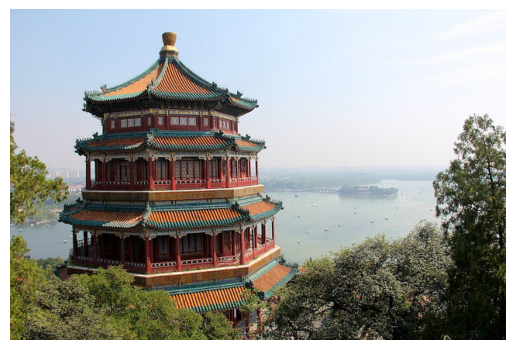

In [57]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.axis("off")
plt.show()

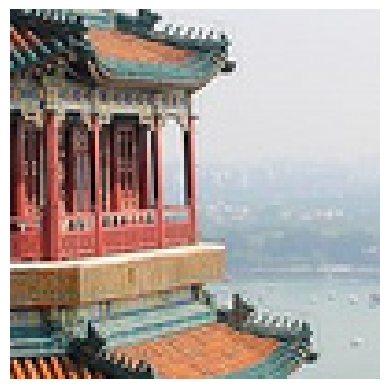

In [58]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

## The Tensorflow Datasets Project

The Tensorflow datasets project(TFDS) makes it very easy to load common datasets.

In [60]:
import tensorflow_datasets as tfds
datasets = tfds.load(name='mnist')
mnist_train, mnist_test = datasets['train'], datasets['test']

2025-01-11 14:19:41.611556: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/home/misha/Desktop/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|█████████████████████████| 5/5 [00:01<00:00,  3.92 file/s]

Dataset mnist downloaded and prepared to /home/misha/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [63]:
mnist_train.shuffle(10_000, seed=42)

<_ShuffleDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [66]:
for item in mnist_train.take(1):
    print(item['image'])
    print(item['label'])

tf.Tensor(
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  

2025-01-11 14:22:30.386464: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [67]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [68]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5


/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7453 - loss: 21.5124 - val_accuracy: 0.8775 - val_loss: 6.3883
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8776 - loss: 5.8115 - val_accuracy: 0.8777 - val_loss: 5.8570
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.8816 - loss: 5.2915 - val_accuracy: 0.8813 - val_loss: 5.9698
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8865 - loss: 5.1140 - val_accuracy: 0.8858 - val_loss: 5.6212
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8883 - loss: 4.8449 - val_accuracy: 0.8620 - val_loss: 6.5559
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.8661 - loss: 6.3957


# Exercises

## 10. 
### a.

In [94]:
## Load dataset
datasets = tfds.load('imdb_reviews', as_supervised=True)

In [95]:
train_set, test_set = datasets['train'], datasets['test']

In [96]:
train_set.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### b.

In [97]:
## Split data
train_set, val_set, test_set = tfds.load('imdb_reviews', 
                                        split=['train', 'test[:15000]', 'test[15000:]'],
                                        as_supervised=True)

In [98]:
len(val_set)

15000

### c.